In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [2]:
MODE = 'DW_SH1N_SH3N_SH4N_SL1_SL2_SL3_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'mobo_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.594987,-0.175653,-0.474627,-0.398148,-1.070338,-0.883826,-0.594987,-0.594987,-0.594987,-0.175653,-0.175653,-0.175653,-0.474627,-0.474627,-0.474627
1,0.594987,0.175653,0.474627,0.398148,1.070338,0.883826,0.594987,0.594987,0.594987,0.175653,0.175653,0.175653,0.474627,0.474627,0.474627


In [3]:
#TEST_MODE = True
TEST_MODE = False

In [4]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.595 -> +3.372
SH3N   : -1.171 + -0.176 -> -1.347
SH4N   : -3.164 + -0.475 -> -3.639
SL1    : -2.654 + -0.398 -> -3.052
SL2    : +7.136 + -1.070 -> +6.065
SL3    : -5.892 + -0.884 -> -6.776
SH1-DW08: +3.967 + -0.595 -> +3.372
SH1-DW18: +3.967 + -0.595 -> +3.372
SH1-DW28: +3.967 + -0.595 -> +3.372
SH3-DW08: -1.171 + -0.176 -> -1.347
SH3-DW18: -1.171 + -0.176 -> -1.347
SH3-DW28: -1.171 + -0.176 -> -1.347
SH4-DW08: -3.164 + -0.475 -> -3.639
SH4-DW18: -3.164 + -0.475 -> -3.639
SH4-DW28: -3.164 + -0.475 -> -3.639


{'SH1N': 3.3715950570000004,
 'SH3N': -1.3466749343,
 'SH4N': -3.6388071633,
 'SL1': -3.0524693915000003,
 'SL2': 6.0652466465,
 'SL3': -6.775997940300001,
 'SH1-DW08': 3.3715950570000004,
 'SH1-DW18': 3.3715950570000004,
 'SH1-DW28': 3.3715950570000004,
 'SH3-DW08': -1.3466749343,
 'SH3-DW18': -1.3466749343,
 'SH3-DW28': -1.3466749343,
 'SH4-DW08': -3.6388071633,
 'SH4-DW18': -3.6388071633,
 'SH4-DW28': -3.6388071633}

### Test eval function

In [ ]:
# Test
if True and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [5]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs, ivals)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 128 #512
gen.numerical_optimizer.n_restarts = 20
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
gen.max_travel_distances = [1.0] * len(gvocs.variables_active)
gen.reference_point = reference_point

[DEBUG][20:01:47.702 __init__.p   47] Creating converter from 7 to 5
[DEBUG][20:01:47.703 __init__.p   47] Creating converter from 5 to 7
[DEBUG][20:01:47.704 __init__.p   47] Creating converter from 7 to 5
[DEBUG][20:01:47.704 __init__.p   47] Creating converter from 5 to 7
[INFO ][20:01:47.812 generator.   16] Initializing generator aps_mobo
[INFO ][20:01:47.814 generator.   64] Initialized generator aps_mobo


In [6]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][20:01:51.018 optimizer.   83] Initializing optimizer with tag='bcbd87b566' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][20:01:51.020 optimizer.  138] Generator set to: supports_batch_generation=True supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1': [-0.39814818150000003, 0.39814818150000003], 'SL2': [-1.0703376435, 1.0703376435], 'SL3': [-0.8838258183000001, 0.8838258183000001], 'SH1-DW08': [-0.594987363, 0.594987363], 'SH1-DW18': [-0.594987363, 0.594987363], 'SH1-DW28': [-0.594987363, 0.594987363], 'SH3-DW08': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW18': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW28': [-0.17565325229999998, 0.17565325229999998], 'SH4-DW08': [-0.4746270213, 0.4746270213], 'SH4-DW18': [-0.4746270213, 0.4746270213], 'SH4-DW28': [-0.4746270213, 0.4746270213]}, c

### Sample at initial values

In [7]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][20:01:57.130 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:01:57.132 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': 0.0, 'SL3': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][20:01:57.136 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 7.135584290000001, 'SL3': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.171021682, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.164180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + +0.000 -> +7.136
SL3    : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.021; RMS(dx, dy) [m] = (7.931e-07, 1.109e-06)
Orbit correction converged


[INFO ][20:02:01.223 opt_funcs.  734] Lifetime measurement START
[INFO ][20:02:06.893 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.973 (raw tau [hr] = 7.017, epsy [pm] = 16.08) (took 5.7 [s])
Inj. Eff. = 87.04 (took 23.2 [s])
Eval. func. finished.


[DEBUG][20:02:30.052 evaluators  211] Result: output={'result': {'_nux': 0.21917589877968563, '_nuy': 0.2660200805491891, '_eps_x_bxbOn': 1.0165654020681953e-09, '_eps_y_bxbOn': 1.6078682464775063e-11, '_eps_x_bxbOff': 1.016942777564496e-09, '_eps_y_bxbOff': 1.6081606132088783e-11, 'LT': 6.9731750502292424, '_raw_LT': 7.016592217548143, 'EFF': 87.04028768157387}, 'exception': None, 'traceback': '', 'wall_time': 32.91919851861894, 'cpu_time': 11.364135695000002}
[DEBUG][20:02:30.055 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:02:30.070 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00000.json] in [0.01070]s


In [8]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,0.219176,0.26602,1.016565e-09,1.607868e-11,1.016943e-09,1.608161e-11,6.973175,7.016592,87.040288


### Sample close to initial point

In [9]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=2, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][20:04:24.588 optimizer.  573] Evaluating 2 inputs
[DEBUG][20:04:24.591 evaluators  193] Data kwargs: row={'SH1-DW08': 0.024927297401066185, 'SH1-DW18': 0.019665358990232206, 'SH1-DW28': -0.020351503397451398, 'SH1N': 0.02642514782431705, 'SH3-DW08': 0.0017629066293680176, 'SH3-DW18': 0.0054797687592474074, 'SH3-DW28': -0.008399823468394432, 'SH3N': 0.0024763513375217552, 'SH4-DW08': 0.004842132110498193, 'SH4-DW18': 0.0027211858511958543, 'SH4-DW28': 0.015451561699142989, 'SH4N': 0.01705249736648358, 'SL1': -0.0165155174397106, 'SL2': 0.028782918903023758, 'SL3': 0.04035095621316943}
[INFO ][20:04:24.596 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9930075678243173, 'SH3N': -1.1685453306624782, 'SH4N': -3.1471276446335166, 'SL1': -2.670836727439711, 'SL2': 7.164367208903024, 'SL3': -5.8518211657868315, 'SH1-DW08': 3.9915097174010667, 'SH1-DW18': 3.9862477789902324, 'SH1-DW28': 3.946230916602549, 'SH3-DW08': -1.1692587753706318, 'SH3-DW18': -1.1655419132407525, 'SH3-DW28': 

SH1N   : +3.967 + +0.026 -> +3.993
SH3N   : -1.171 + +0.002 -> -1.169
SH4N   : -3.164 + +0.017 -> -3.147
SL1    : -2.654 + -0.017 -> -2.671
SL2    : +7.136 + +0.029 -> +7.164
SL3    : -5.892 + +0.040 -> -5.852
SH1-DW08: +3.967 + +0.025 -> +3.992
SH1-DW18: +3.967 + +0.020 -> +3.986
SH1-DW28: +3.967 + -0.020 -> +3.946
SH3-DW08: -1.171 + +0.002 -> -1.169
SH3-DW18: -1.171 + +0.005 -> -1.166
SH3-DW28: -1.171 + -0.008 -> -1.179
SH4-DW08: -3.164 + +0.005 -> -3.159
SH4-DW18: -3.164 + +0.003 -> -3.161
SH4-DW28: -3.164 + +0.015 -> -3.149
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.033; RMS(dx, dy) [m] = (1.002e-06, 1.084e-06)
Orbit correction converged


[INFO ][20:04:28.673 opt_funcs.  734] Lifetime measurement START
[INFO ][20:04:36.631 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.186 (raw tau [hr] = 7.423, epsy [pm] = 16.79) (took 8.0 [s])
Inj. Eff. = 79.57 (took 20.1 [s])
Eval. func. finished.


[DEBUG][20:04:56.767 evaluators  211] Result: output={'result': {'_nux': 0.2202745138270675, '_nuy': 0.2653792217715497, '_eps_x_bxbOn': 1.014695418398621e-09, '_eps_y_bxbOn': 1.687159851419728e-11, '_eps_x_bxbOff': 1.0155350158728232e-09, '_eps_y_bxbOff': 1.6785057528897704e-11, 'LT': 7.186479356109095, '_raw_LT': 7.42347080350426, 'EFF': 79.5661865357408}, 'exception': None, 'traceback': '', 'wall_time': 32.17486252449453, 'cpu_time': 13.430021492000002}
[DEBUG][20:04:56.767 evaluators  193] Data kwargs: row={'SH1-DW08': -0.029235853824873963, 'SH1-DW18': -0.015280130625038194, 'SH1-DW28': 0.025141434613460484, 'SH1N': -0.027684371953286206, 'SH3-DW08': -0.0005796732221714559, 'SH3-DW18': -0.0008423172279650969, 'SH3-DW28': 0.003923386088341916, 'SH3N': -0.007394794220869027, 'SH4-DW08': -0.004434268331259719, 'SH4-DW18': -0.021703354587411284, 'SH4-DW28': -0.018224467912756188, 'SH4N': -0.016005217894693922, 'SL1': 0.00924655691859471, 'SL2': -0.032984536537172135, 'SL3': -0.0311050

SH1N   : +3.967 + -0.028 -> +3.939
SH3N   : -1.171 + -0.007 -> -1.178
SH4N   : -3.164 + -0.016 -> -3.180
SL1    : -2.654 + +0.009 -> -2.645
SL2    : +7.136 + -0.033 -> +7.103
SL3    : -5.892 + -0.031 -> -5.923
SH1-DW08: +3.967 + -0.029 -> +3.937
SH1-DW18: +3.967 + -0.015 -> +3.951
SH1-DW28: +3.967 + +0.025 -> +3.992
SH3-DW08: -1.171 + -0.001 -> -1.172
SH3-DW18: -1.171 + -0.001 -> -1.172
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + -0.004 -> -3.169
SH4-DW18: -3.164 + -0.022 -> -3.186
SH4-DW28: -3.164 + -0.018 -> -3.182
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (1.264e-06, 1.122e-06)
Orbit correction converged


[INFO ][20:05:00.846 opt_funcs.  734] Lifetime measurement START
[INFO ][20:05:14.341 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.867 (raw tau [hr] = 6.792, epsy [pm] = 15.36) (took 13.5 [s])
Inj. Eff. = 91.72 (took 20.1 [s])
Eval. func. finished.


[DEBUG][20:05:34.466 evaluators  211] Result: output={'result': {'_nux': 0.2180772635779276, '_nuy': 0.2660200906263772, '_eps_x_bxbOn': 1.0186438428871222e-09, '_eps_y_bxbOn': 1.542094012028156e-11, '_eps_x_bxbOff': 1.01883854173629e-09, '_eps_y_bxbOff': 1.5360965577823276e-11, 'LT': 6.86712951899101, '_raw_LT': 6.791881417084153, 'EFF': 91.72168371668039}, 'exception': None, 'traceback': '', 'wall_time': 37.69786343164742, 'cpu_time': 19.62809585}
[DEBUG][20:05:34.469 optimizer.  291] Adding (2) new data to internal dataframes
[DEBUG][20:05:34.486 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00001.json] in [0.01176]s


In [10]:
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,True,0.219176,0.266020,1.016565e-09,1.607868e-11,1.016943e-09,1.608161e-11,6.973175,7.016592,87.040288
2,0.026425,0.002476,0.017052,-0.016516,0.028783,0.040351,0.024927,0.019665,-0.020352,0.001763,...,True,0.220275,0.265379,1.014695e-09,1.687160e-11,1.015535e-09,1.678506e-11,7.186479,7.423471,79.566187
3,-0.027684,-0.007395,-0.016005,0.009247,-0.032985,-0.031105,-0.029236,-0.015280,0.025141,-0.000580,...,True,0.218077,0.266020,1.018644e-09,1.542094e-11,1.018839e-09,1.536097e-11,6.867130,6.791881,91.721684


### Run optimizer

In [11]:
opt.step()

[DEBUG][20:06:28.235 optimizer.  447] Generating 1 candidates
[DEBUG][20:06:28.242 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1': [-0.39814818150000003, 0.39814818150000003], 'SL2': [-1.0703376435, 1.0703376435], 'SL3': [-0.8838258183000001, 0.8838258183000001], 'SH1-DW08': [-0.594987363, 0.594987363], 'SH1-DW18': [-0.594987363, 0.594987363], 'SH1-DW28': [-0.594987363, 0.594987363], 'SH3-DW08': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW18': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW28': [-0.17565325229999998, 0.17565325229999998], 'SH4-DW08': [-0.4746270213, 0.4746270213], 'SH4-DW18': [-0.4746270213, 0.4746270213], 'SH4-DW28': [-0.4746270213, 0.4746270213]}, constraints={}, objectives={'LT': 'MAXIMIZE', 'EFF': 'MAXIMIZE'}, constants={}, observables=[]) with len(data)=3
[INFO ][20:06:28.488    mobo.py  301] Mob

SH1N   : +3.967 + -0.125 -> +3.842
SH3N   : -1.171 + +0.001 -> -1.170
SH4N   : -3.164 + -0.085 -> -3.249
SL1    : -2.654 + +0.098 -> -2.557
SL2    : +7.136 + -0.129 -> +7.007
SL3    : -5.892 + -0.217 -> -6.109
SH1-DW08: +3.967 + -0.110 -> +3.856
SH1-DW18: +3.967 + -0.106 -> +3.860
SH1-DW28: +3.967 + +0.087 -> +4.053
SH3-DW08: -1.171 + -0.012 -> -1.183
SH3-DW18: -1.171 + -0.039 -> -1.210
SH3-DW28: -1.171 + +0.051 -> -1.120
SH4-DW08: -3.164 + -0.025 -> -3.189
SH4-DW18: -3.164 + +0.041 -> -3.124
SH4-DW28: -3.164 + -0.068 -> -3.232
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.116; RMS(dx, dy) [m] = (9.971e-06, 1.100e-06)
Max FCOR I [A] = 0.116; RMS(dx, dy) [m] = (9.971e-06, 1.100e-06)
Max FCOR I [A] = 0.035; RMS(dx, dy) [m] = (1.956e-06, 1.107e-06)
Orbit correction converged


[INFO ][20:06:39.572 opt_funcs.  734] Lifetime measurement START
[INFO ][20:06:44.089 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.296 (raw tau [hr] = 5.838, epsy [pm] = 13.43) (took 4.5 [s])
Inj. Eff. = 13.71 (took 19.0 [s])
Eval. func. finished.


[DEBUG][20:07:03.108 evaluators  211] Result: output={'result': {'_nux': 0.21545278086182013, '_nuy': 0.26922441474613856, '_eps_x_bxbOn': 1.030741402058106e-09, '_eps_y_bxbOn': 1.3578409877351085e-11, '_eps_x_bxbOff': 1.0295854732410738e-09, '_eps_y_bxbOff': 1.3431074529349086e-11, 'LT': 6.296004680245148, '_raw_LT': 5.837792662608662, 'EFF': 13.710310868010172}, 'exception': None, 'traceback': '', 'wall_time': 31.669447265565395, 'cpu_time': 16.742459644999997}
[DEBUG][20:07:03.111 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:07:03.126 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00002.json] in [0.01022]s


In [12]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][20:07:21.795 optimizer.  447] Generating 1 candidates
[DEBUG][20:07:21.802 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1': [-0.39814818150000003, 0.39814818150000003], 'SL2': [-1.0703376435, 1.0703376435], 'SL3': [-0.8838258183000001, 0.8838258183000001], 'SH1-DW08': [-0.594987363, 0.594987363], 'SH1-DW18': [-0.594987363, 0.594987363], 'SH1-DW28': [-0.594987363, 0.594987363], 'SH3-DW08': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW18': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW28': [-0.17565325229999998, 0.17565325229999998], 'SH4-DW08': [-0.4746270213, 0.4746270213], 'SH4-DW18': [-0.4746270213, 0.4746270213], 'SH4-DW28': [-0.4746270213, 0.4746270213]}, constraints={}, objectives={'LT': 'MAXIMIZE', 'EFF': 'MAXIMIZE'}, constants={}, observables=[]) with len(data)=4



** Step #1 at 2023-12-16 20:07:21**



[INFO ][20:07:22.422    mobo.py  301] Mobo called with inputs.size()=torch.Size([4, 15])
[DEBUG][20:07:24.154 bayesian_g  110] Optimize results: tensor([[-0.0549,  0.0247,  0.0549, -0.0321,  0.0105,  0.0370, -0.0240, -0.0501,
          0.0022, -0.1988, -0.0338, -0.0029, -0.0433, -0.0530,  0.0326]],
       dtype=torch.float64)
[DEBUG][20:07:24.155 bayesian_g  248] Best candidate from optimize tensor([[-0.0549,  0.0247,  0.0549, -0.0321,  0.0105,  0.0370, -0.0240, -0.0501,
          0.0022, -0.1988, -0.0338, -0.0029, -0.0433, -0.0530,  0.0326]],
       dtype=torch.float64)
[DEBUG][20:07:24.157 optimizer.  488] Generated 1 inputs
[INFO ][20:07:24.160 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:07:24.162 evaluators  193] Data kwargs: row={'SH1-DW08': -0.054869732214885336, 'SH1-DW18': 0.024719507659196463, 'SH1-DW28': 0.05487479186570433, 'SH1N': -0.03214775098298064, 'SH3-DW08': 0.010537038352353726, 'SH3-DW18': 0.03697965670081909, 'SH3-DW28': -0.024018725169819274, 'SH3N': -0.050062

SH1N   : +3.967 + -0.032 -> +3.934
SH3N   : -1.171 + -0.050 -> -1.221
SH4N   : -3.164 + -0.003 -> -3.167
SL1    : -2.654 + -0.043 -> -2.698
SL2    : +7.136 + -0.053 -> +7.083
SL3    : -5.892 + +0.033 -> -5.860
SH1-DW08: +3.967 + -0.055 -> +3.912
SH1-DW18: +3.967 + +0.025 -> +3.991
SH1-DW28: +3.967 + +0.055 -> +4.021
SH3-DW08: -1.171 + +0.011 -> -1.160
SH3-DW18: -1.171 + +0.037 -> -1.134
SH3-DW28: -1.171 + -0.024 -> -1.195
SH4-DW08: -3.164 + +0.002 -> -3.162
SH4-DW18: -3.164 + -0.199 -> -3.363
SH4-DW28: -3.164 + -0.034 -> -3.198
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.068; RMS(dx, dy) [m] = (8.259e-06, 1.122e-06)
Orbit correction converged


[INFO ][20:07:31.319 opt_funcs.  734] Lifetime measurement START
[INFO ][20:07:39.348 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.855 (raw tau [hr] = 6.765, epsy [pm] = 15.16) (took 8.0 [s])
Inj. Eff. = 92.10 (took 18.8 [s])
Eval. func. finished.


[DEBUG][20:07:58.131 evaluators  211] Result: output={'result': {'_nux': 0.2187791699611168, '_nuy': 0.2673933695127926, '_eps_x_bxbOn': 1.024498554419845e-09, '_eps_y_bxbOn': 1.5253122920432985e-11, '_eps_x_bxbOff': 1.0192997785803114e-09, '_eps_y_bxbOff': 1.515801403631086e-11, 'LT': 6.854726748381058, '_raw_LT': 6.7648289524014205, 'EFF': 92.10395205480872}, 'exception': None, 'traceback': '', 'wall_time': 33.96796113997698, 'cpu_time': 20.119059271000026}
[DEBUG][20:07:58.134 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:07:58.153 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00003.json] in [0.01264]s
[DEBUG][20:07:58.154 optimizer.  447] Generating 1 candidates
[DEBUG][20:07:58.158 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1


** Step #2 at 2023-12-16 20:07:58**



[INFO ][20:07:58.645    mobo.py  301] Mobo called with inputs.size()=torch.Size([5, 15])
[DEBUG][20:08:01.994 bayesian_g  110] Optimize results: tensor([[-0.0957, -0.0208,  0.0989, -0.0666, -0.0015,  0.0345, -0.0494, -0.0182,
         -0.0217, -0.0014, -0.0718, -0.0402, -0.0526, -0.1405,  0.0369]],
       dtype=torch.float64)
[DEBUG][20:08:01.995 bayesian_g  248] Best candidate from optimize tensor([[-0.0957, -0.0208,  0.0989, -0.0666, -0.0015,  0.0345, -0.0494, -0.0182,
         -0.0217, -0.0014, -0.0718, -0.0402, -0.0526, -0.1405,  0.0369]],
       dtype=torch.float64)
[DEBUG][20:08:01.997 optimizer.  488] Generated 1 inputs
[INFO ][20:08:02.001 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:08:02.002 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09565840639075474, 'SH1-DW18': -0.020786881234892994, 'SH1-DW28': 0.09886336625187851, 'SH1N': -0.0665816436929967, 'SH3-DW08': -0.0015258980830843542, 'SH3-DW18': 0.03445188424212052, 'SH3-DW28': -0.04935412881988741, 'SH3N': -0.018183

SH1N   : +3.967 + -0.067 -> +3.900
SH3N   : -1.171 + -0.018 -> -1.189
SH4N   : -3.164 + -0.040 -> -3.204
SL1    : -2.654 + -0.053 -> -2.707
SL2    : +7.136 + -0.140 -> +6.995
SL3    : -5.892 + +0.037 -> -5.855
SH1-DW08: +3.967 + -0.096 -> +3.871
SH1-DW18: +3.967 + -0.021 -> +3.946
SH1-DW28: +3.967 + +0.099 -> +4.065
SH3-DW08: -1.171 + -0.002 -> -1.173
SH3-DW18: -1.171 + +0.034 -> -1.137
SH3-DW28: -1.171 + -0.049 -> -1.220
SH4-DW08: -3.164 + -0.022 -> -3.186
SH4-DW18: -3.164 + -0.001 -> -3.166
SH4-DW28: -3.164 + -0.072 -> -3.236
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.064; RMS(dx, dy) [m] = (3.027e-06, 1.128e-06)
Orbit correction converged


[INFO ][20:08:08.120 opt_funcs.  734] Lifetime measurement START
[INFO ][20:08:13.565 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.668 (raw tau [hr] = 6.463, epsy [pm] = 14.59) (took 5.4 [s])
Inj. Eff. = 83.58 (took 18.2 [s])
Eval. func. finished.


[DEBUG][20:08:31.756 evaluators  211] Result: output={'result': {'_nux': 0.21755846977982346, '_nuy': 0.2673933695127926, '_eps_x_bxbOn': 1.0198366267282616e-09, '_eps_y_bxbOn': 1.4756012817583822e-11, '_eps_x_bxbOff': 1.0199694224980154e-09, '_eps_y_bxbOff': 1.4593024010402296e-11, 'LT': 6.667900652353452, '_raw_LT': 6.4625947118454175, 'EFF': 83.57968647027599}, 'exception': None, 'traceback': '', 'wall_time': 29.75275330338627, 'cpu_time': 17.68480175000002}
[DEBUG][20:08:31.759 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:08:31.782 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00004.json] in [0.01692]s
[DEBUG][20:08:31.783 optimizer.  447] Generating 1 candidates
[DEBUG][20:08:31.788 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'S


** Step #3 at 2023-12-16 20:08:31**



[INFO ][20:08:32.433    mobo.py  301] Mobo called with inputs.size()=torch.Size([6, 15])
[DEBUG][20:08:37.170 bayesian_g  110] Optimize results: tensor([[ 0.0364, -0.0508, -0.0354, -0.0509, -0.0054,  0.0087, -0.0304, -0.0421,
         -0.0205, -0.1625,  0.0063, -0.0392, -0.0002, -0.0390, -0.0775]],
       dtype=torch.float64)
[DEBUG][20:08:37.171 bayesian_g  248] Best candidate from optimize tensor([[ 0.0364, -0.0508, -0.0354, -0.0509, -0.0054,  0.0087, -0.0304, -0.0421,
         -0.0205, -0.1625,  0.0063, -0.0392, -0.0002, -0.0390, -0.0775]],
       dtype=torch.float64)
[DEBUG][20:08:37.173 optimizer.  488] Generated 1 inputs
[INFO ][20:08:37.177 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:08:37.178 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03637656149593966, 'SH1-DW18': -0.05082323403356671, 'SH1-DW28': -0.0354045732877958, 'SH1N': -0.0509486605898305, 'SH3-DW08': -0.005422796828432818, 'SH3-DW18': 0.008656146733055098, 'SH3-DW28': -0.030431660972480228, 'SH3N': -0.0421171

SH1N   : +3.967 + -0.051 -> +3.916
SH3N   : -1.171 + -0.042 -> -1.213
SH4N   : -3.164 + -0.039 -> -3.203
SL1    : -2.654 + -0.000 -> -2.655
SL2    : +7.136 + -0.039 -> +7.097
SL3    : -5.892 + -0.077 -> -5.970
SH1-DW08: +3.967 + +0.036 -> +4.003
SH1-DW18: +3.967 + -0.051 -> +3.916
SH1-DW28: +3.967 + -0.035 -> +3.931
SH3-DW08: -1.171 + -0.005 -> -1.176
SH3-DW18: -1.171 + +0.009 -> -1.162
SH3-DW28: -1.171 + -0.030 -> -1.201
SH4-DW08: -3.164 + -0.021 -> -3.185
SH4-DW18: -3.164 + -0.162 -> -3.327
SH4-DW28: -3.164 + +0.006 -> -3.158
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.083; RMS(dx, dy) [m] = (1.761e-06, 1.125e-06)
Orbit correction converged


[INFO ][20:08:42.385 opt_funcs.  734] Lifetime measurement START
[INFO ][20:08:48.313 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.737 (raw tau [hr] = 6.561, epsy [pm] = 14.70) (took 5.9 [s])
Inj. Eff. = 84.74 (took 19.1 [s])
Eval. func. finished.


[DEBUG][20:09:07.414 evaluators  211] Result: output={'result': {'_nux': 0.2178331235416689, '_nuy': 0.26754595829510275, '_eps_x_bxbOn': 1.0189281334778274e-09, '_eps_y_bxbOn': 1.483688577668576e-11, '_eps_x_bxbOff': 1.0206757961212795e-09, '_eps_y_bxbOff': 1.4703705584250534e-11, 'LT': 6.737303154538678, '_raw_LT': 6.561370119081869, 'EFF': 84.73726254755115}, 'exception': None, 'traceback': '', 'wall_time': 30.23480544053018, 'cpu_time': 17.922042919999967}
[DEBUG][20:09:07.418 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:09:07.435 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00005.json] in [0.01297]s
[DEBUG][20:09:07.436 optimizer.  447] Generating 1 candidates
[DEBUG][20:09:07.440 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #4 at 2023-12-16 20:09:07**



[INFO ][20:09:08.600    mobo.py  301] Mobo called with inputs.size()=torch.Size([7, 15])
[DEBUG][20:09:13.529 bayesian_g  110] Optimize results: tensor([[-0.1153,  0.0343,  0.0996,  0.0387,  0.0062,  0.0095, -0.0115, -0.0273,
          0.0065, -0.1332, -0.0501,  0.0437,  0.0025, -0.0108, -0.0322]],
       dtype=torch.float64)
[DEBUG][20:09:13.531 bayesian_g  248] Best candidate from optimize tensor([[-0.1153,  0.0343,  0.0996,  0.0387,  0.0062,  0.0095, -0.0115, -0.0273,
          0.0065, -0.1332, -0.0501,  0.0437,  0.0025, -0.0108, -0.0322]],
       dtype=torch.float64)
[DEBUG][20:09:13.534 optimizer.  488] Generated 1 inputs
[INFO ][20:09:13.538 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:09:13.541 evaluators  193] Data kwargs: row={'SH1-DW08': -0.11534373009019262, 'SH1-DW18': 0.03428792411370203, 'SH1-DW28': 0.09959944124838661, 'SH1N': 0.038686212836225684, 'SH3-DW08': 0.006194891814193272, 'SH3-DW18': 0.009533095845955464, 'SH3-DW28': -0.01146939366902174, 'SH3N': -0.02728483

SH1N   : +3.967 + +0.039 -> +4.005
SH3N   : -1.171 + -0.027 -> -1.198
SH4N   : -3.164 + +0.044 -> -3.121
SL1    : -2.654 + +0.002 -> -2.652
SL2    : +7.136 + -0.011 -> +7.125
SL3    : -5.892 + -0.032 -> -5.924
SH1-DW08: +3.967 + -0.115 -> +3.851
SH1-DW18: +3.967 + +0.034 -> +4.001
SH1-DW28: +3.967 + +0.100 -> +4.066
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.010 -> -1.161
SH3-DW28: -1.171 + -0.011 -> -1.182
SH4-DW08: -3.164 + +0.006 -> -3.158
SH4-DW18: -3.164 + -0.133 -> -3.297
SH4-DW28: -3.164 + -0.050 -> -3.214
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.014; RMS(dx, dy) [m] = (1.016e-06, 1.147e-06)
Orbit correction converged


[INFO ][20:09:18.638 opt_funcs.  734] Lifetime measurement START
[INFO ][20:09:24.626 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.148 (raw tau [hr] = 7.277, epsy [pm] = 16.03) (took 6.0 [s])
Inj. Eff. = 85.75 (took 18.4 [s])
Eval. func. finished.


[DEBUG][20:09:43.075 evaluators  211] Result: output={'result': {'_nux': 0.21714140183659278, '_nuy': 0.2666609594812047, '_eps_x_bxbOn': 1.0163004680687495e-09, '_eps_y_bxbOn': 1.62837277113674e-11, '_eps_x_bxbOff': 1.017481272833396e-09, '_eps_y_bxbOff': 1.6032135919191906e-11, 'LT': 7.1475110889465245, '_raw_LT': 7.276649247500875, 'EFF': 85.74898583392925}, 'exception': None, 'traceback': '', 'wall_time': 29.532872853800654, 'cpu_time': 17.883437077000053}
[DEBUG][20:09:43.077 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:09:43.097 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00006.json] in [0.01498]s
[DEBUG][20:09:43.097 optimizer.  447] Generating 1 candidates
[DEBUG][20:09:43.104 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #5 at 2023-12-16 20:09:43**



[INFO ][20:09:43.537    mobo.py  301] Mobo called with inputs.size()=torch.Size([8, 15])
[DEBUG][20:09:48.077 bayesian_g  110] Optimize results: tensor([[-0.0391, -0.0025,  0.0431, -0.0519,  0.0095,  0.0269,  0.0065, -0.0312,
          0.0012, -0.0987, -0.0332, -0.0443, -0.0319, -0.0897,  0.0398]],
       dtype=torch.float64)
[DEBUG][20:09:48.079 bayesian_g  248] Best candidate from optimize tensor([[-0.0391, -0.0025,  0.0431, -0.0519,  0.0095,  0.0269,  0.0065, -0.0312,
          0.0012, -0.0987, -0.0332, -0.0443, -0.0319, -0.0897,  0.0398]],
       dtype=torch.float64)
[DEBUG][20:09:48.081 optimizer.  488] Generated 1 inputs
[INFO ][20:09:48.084 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:09:48.085 evaluators  193] Data kwargs: row={'SH1-DW08': -0.03908331022751944, 'SH1-DW18': -0.0024666042809971486, 'SH1-DW28': 0.043064051979117876, 'SH1N': -0.05193319814838254, 'SH3-DW08': 0.009486992392443383, 'SH3-DW18': 0.02689935155201201, 'SH3-DW28': 0.0065492976623046355, 'SH3N': -0.0311

SH1N   : +3.967 + -0.052 -> +3.915
SH3N   : -1.171 + -0.031 -> -1.202
SH4N   : -3.164 + -0.044 -> -3.208
SL1    : -2.654 + -0.032 -> -2.686
SL2    : +7.136 + -0.090 -> +7.046
SL3    : -5.892 + +0.040 -> -5.852
SH1-DW08: +3.967 + -0.039 -> +3.927
SH1-DW18: +3.967 + -0.002 -> +3.964
SH1-DW28: +3.967 + +0.043 -> +4.010
SH3-DW08: -1.171 + +0.009 -> -1.162
SH3-DW18: -1.171 + +0.027 -> -1.144
SH3-DW28: -1.171 + +0.007 -> -1.164
SH4-DW08: -3.164 + +0.001 -> -3.163
SH4-DW18: -3.164 + -0.099 -> -3.263
SH4-DW28: -3.164 + -0.033 -> -3.197
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (9.067e-07, 1.147e-06)
Orbit correction converged


[INFO ][20:09:53.188 opt_funcs.  734] Lifetime measurement START
[INFO ][20:09:59.680 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.873 (raw tau [hr] = 6.782, epsy [pm] = 15.04) (took 6.5 [s])
Inj. Eff. = 87.65 (took 19.1 [s])
Eval. func. finished.


[DEBUG][20:10:18.740 evaluators  211] Result: output={'result': {'_nux': 0.21822986243742587, '_nuy': 0.2669356132430502, '_eps_x_bxbOn': 1.0191961163791391e-09, '_eps_y_bxbOn': 1.5192947182743862e-11, '_eps_x_bxbOff': 1.0218847166178691e-09, '_eps_y_bxbOff': 1.504487451687928e-11, 'LT': 6.873110432387923, '_raw_LT': 6.782084867259061, 'EFF': 87.64933601032025}, 'exception': None, 'traceback': '', 'wall_time': 30.654122727923095, 'cpu_time': 18.72252065600003}
[DEBUG][20:10:18.743 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:10:18.763 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00007.json] in [0.01498]s
[DEBUG][20:10:18.763 optimizer.  447] Generating 1 candidates
[DEBUG][20:10:18.768 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #6 at 2023-12-16 20:10:18**



[INFO ][20:10:19.565    mobo.py  301] Mobo called with inputs.size()=torch.Size([9, 15])
[DEBUG][20:10:24.058 bayesian_g  110] Optimize results: tensor([[-0.0583,  0.0419,  0.0490, -0.1286,  0.0034,  0.0144, -0.0240, -0.0214,
          0.0030, -0.1105, -0.0177,  0.0275, -0.0069,  0.0273, -0.0151]],
       dtype=torch.float64)
[DEBUG][20:10:24.059 bayesian_g  248] Best candidate from optimize tensor([[-0.0583,  0.0419,  0.0490, -0.1286,  0.0034,  0.0144, -0.0240, -0.0214,
          0.0030, -0.1105, -0.0177,  0.0275, -0.0069,  0.0273, -0.0151]],
       dtype=torch.float64)
[DEBUG][20:10:24.061 optimizer.  488] Generated 1 inputs
[INFO ][20:10:24.064 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:10:24.066 evaluators  193] Data kwargs: row={'SH1-DW08': -0.0582993768736313, 'SH1-DW18': 0.04186854409637552, 'SH1-DW28': 0.048979001780260996, 'SH1N': -0.1285694556344424, 'SH3-DW08': 0.0034090620125204496, 'SH3-DW18': 0.014411842397372742, 'SH3-DW28': -0.024047351522435326, 'SH3N': -0.0214042

SH1N   : +3.967 + -0.129 -> +3.838
SH3N   : -1.171 + -0.021 -> -1.192
SH4N   : -3.164 + +0.028 -> -3.137
SL1    : -2.654 + -0.007 -> -2.661
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.015 -> -5.907
SH1-DW08: +3.967 + -0.058 -> +3.908
SH1-DW18: +3.967 + +0.042 -> +4.008
SH1-DW28: +3.967 + +0.049 -> +4.016
SH3-DW08: -1.171 + +0.003 -> -1.168
SH3-DW18: -1.171 + +0.014 -> -1.157
SH3-DW28: -1.171 + -0.024 -> -1.195
SH4-DW08: -3.164 + +0.003 -> -3.161
SH4-DW18: -3.164 + -0.111 -> -3.275
SH4-DW28: -3.164 + -0.018 -> -3.182
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (9.284e-07, 1.128e-06)
Orbit correction converged


[INFO ][20:10:29.159 opt_funcs.  734] Lifetime measurement START
[INFO ][20:10:35.018 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.872 (raw tau [hr] = 6.843, epsy [pm] = 15.28) (took 5.9 [s])
Inj. Eff. = 88.45 (took 18.4 [s])
Eval. func. finished.


[DEBUG][20:10:53.379 evaluators  211] Result: output={'result': {'_nux': 0.2189927962717887, '_nuy': 0.2666304356784298, '_eps_x_bxbOn': 1.0205468254833795e-09, '_eps_y_bxbOn': 1.5391983222788944e-11, '_eps_x_bxbOff': 1.0204958225767521e-09, '_eps_y_bxbOff': 1.528297249347084e-11, 'LT': 6.872450614315906, '_raw_LT': 6.8432970323796765, 'EFF': 88.4454080924796}, 'exception': None, 'traceback': '', 'wall_time': 29.312481066212058, 'cpu_time': 17.783214498999996}
[DEBUG][20:10:53.380 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:10:53.402 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00008.json] in [0.01707]s
[DEBUG][20:10:53.403 optimizer.  447] Generating 1 candidates
[DEBUG][20:10:53.407 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #7 at 2023-12-16 20:10:53**



[INFO ][20:10:54.215    mobo.py  301] Mobo called with inputs.size()=torch.Size([10, 15])
[DEBUG][20:10:59.039 bayesian_g  110] Optimize results: tensor([[ 0.0200,  0.0816, -0.0031,  0.1226,  0.0154,  0.0316, -0.0016, -0.0138,
          0.0216, -0.0724,  0.0048,  0.0588, -0.0710,  0.0264, -0.0485]],
       dtype=torch.float64)
[DEBUG][20:10:59.040 bayesian_g  248] Best candidate from optimize tensor([[ 0.0200,  0.0816, -0.0031,  0.1226,  0.0154,  0.0316, -0.0016, -0.0138,
          0.0216, -0.0724,  0.0048,  0.0588, -0.0710,  0.0264, -0.0485]],
       dtype=torch.float64)
[DEBUG][20:10:59.042 optimizer.  488] Generated 1 inputs
[INFO ][20:10:59.046 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:10:59.047 evaluators  193] Data kwargs: row={'SH1-DW08': 0.02000439867809102, 'SH1-DW18': 0.08157473679600513, 'SH1-DW28': -0.00313888142239852, 'SH1N': 0.1226317935568388, 'SH3-DW08': 0.015354830434121619, 'SH3-DW18': 0.03155653434881763, 'SH3-DW28': -0.001584425501007182, 'SH3N': -0.013781312

SH1N   : +3.967 + +0.123 -> +4.089
SH3N   : -1.171 + -0.014 -> -1.185
SH4N   : -3.164 + +0.059 -> -3.105
SL1    : -2.654 + -0.071 -> -2.725
SL2    : +7.136 + +0.026 -> +7.162
SL3    : -5.892 + -0.049 -> -5.941
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.082 -> +4.048
SH1-DW28: +3.967 + -0.003 -> +3.963
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + +0.032 -> -1.139
SH3-DW28: -1.171 + -0.002 -> -1.173
SH4-DW08: -3.164 + +0.022 -> -3.143
SH4-DW18: -3.164 + -0.072 -> -3.237
SH4-DW28: -3.164 + +0.005 -> -3.159
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.114; RMS(dx, dy) [m] = (5.290e-06, 1.144e-06)
Max FCOR I [A] = 0.114; RMS(dx, dy) [m] = (5.290e-06, 1.144e-06)
Max FCOR I [A] = 0.038; RMS(dx, dy) [m] = (2.065e-06, 1.167e-06)
Orbit correction converged


[INFO ][20:11:08.188 opt_funcs.  734] Lifetime measurement START
[INFO ][20:11:15.085 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.166 (raw tau [hr] = 7.540, epsy [pm] = 17.03) (took 6.9 [s])
Inj. Eff. = 72.90 (took 19.0 [s])
Eval. func. finished.


[DEBUG][20:11:34.134 evaluators  211] Result: output={'result': {'_nux': 0.22070176644841125, '_nuy': 0.2657759505901185, '_eps_x_bxbOn': 1.0148318606058123e-09, '_eps_y_bxbOn': 1.7036818044081345e-11, '_eps_x_bxbOff': 1.0143419865399626e-09, '_eps_y_bxbOff': 1.7028167203675115e-11, 'LT': 7.165520141490176, '_raw_LT': 7.539971475810211, 'EFF': 72.89945096520253}, 'exception': None, 'traceback': '', 'wall_time': 35.08541342057288, 'cpu_time': 18.78781183199999}
[DEBUG][20:11:34.136 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:11:34.156 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00009.json] in [0.01619]s
[DEBUG][20:11:34.157 optimizer.  447] Generating 1 candidates
[DEBUG][20:11:34.160 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #8 at 2023-12-16 20:11:34**



[INFO ][20:11:34.595    mobo.py  301] Mobo called with inputs.size()=torch.Size([11, 15])
[DEBUG][20:11:47.547 bayesian_g  110] Optimize results: tensor([[-0.0676, -0.0453,  0.0667, -0.0809, -0.0019,  0.0179, -0.0147, -0.0290,
         -0.0215, -0.0626, -0.0574, -0.0550, -0.0126, -0.1354, -0.0466]],
       dtype=torch.float64)
[DEBUG][20:11:47.548 bayesian_g  248] Best candidate from optimize tensor([[-0.0676, -0.0453,  0.0667, -0.0809, -0.0019,  0.0179, -0.0147, -0.0290,
         -0.0215, -0.0626, -0.0574, -0.0550, -0.0126, -0.1354, -0.0466]],
       dtype=torch.float64)
[DEBUG][20:11:47.550 optimizer.  488] Generated 1 inputs
[INFO ][20:11:47.554 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:11:47.555 evaluators  193] Data kwargs: row={'SH1-DW08': -0.06762113194109431, 'SH1-DW18': -0.045328462798820766, 'SH1-DW28': 0.06670594209851209, 'SH1N': -0.08087155370402759, 'SH3-DW08': -0.0018887044026602725, 'SH3-DW18': 0.017923832197471443, 'SH3-DW28': -0.01473167702630454, 'SH3N': -0.028

SH1N   : +3.967 + -0.081 -> +3.886
SH3N   : -1.171 + -0.029 -> -1.200
SH4N   : -3.164 + -0.055 -> -3.219
SL1    : -2.654 + -0.013 -> -2.667
SL2    : +7.136 + -0.135 -> +7.000
SL3    : -5.892 + -0.047 -> -5.939
SH1-DW08: +3.967 + -0.068 -> +3.899
SH1-DW18: +3.967 + -0.045 -> +3.921
SH1-DW28: +3.967 + +0.067 -> +4.033
SH3-DW08: -1.171 + -0.002 -> -1.173
SH3-DW18: -1.171 + +0.018 -> -1.153
SH3-DW28: -1.171 + -0.015 -> -1.186
SH4-DW08: -3.164 + -0.021 -> -3.186
SH4-DW18: -3.164 + -0.063 -> -3.227
SH4-DW28: -3.164 + -0.057 -> -3.222
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.134; RMS(dx, dy) [m] = (1.702e-05, 1.182e-06)
Max FCOR I [A] = 0.134; RMS(dx, dy) [m] = (1.702e-05, 1.182e-06)
Max FCOR I [A] = 0.116; RMS(dx, dy) [m] = (3.096e-06, 1.147e-06)
Max FCOR I [A] = 0.116; RMS(dx, dy) [m] = (3.096e-06, 1.147e-06)
Max FCOR I [A] = 0.068; RMS(dx, dy) [m] = (2.420e-06, 1.150e-06)
Orbit correction converged


[INFO ][20:11:57.676 opt_funcs.  734] Lifetime measurement START
[INFO ][20:12:03.040 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.622 (raw tau [hr] = 6.341, epsy [pm] = 14.07) (took 5.4 [s])
Inj. Eff. = 63.49 (took 20.0 [s])
Eval. func. finished.


[DEBUG][20:12:23.044 evaluators  211] Result: output={'result': {'_nux': 0.22355005007611553, '_nuy': 0.26791216331089673, '_eps_x_bxbOn': 1.0214370615440452e-09, '_eps_y_bxbOn': 1.4261425686433511e-11, '_eps_x_bxbOff': 1.0229379653604821e-09, '_eps_y_bxbOff': 1.406912502792038e-11, 'LT': 6.622314929725303, '_raw_LT': 6.341416678768322, 'EFF': 63.49394746052519}, 'exception': None, 'traceback': '', 'wall_time': 35.48786658141762, 'cpu_time': 17.41052190100004}
[DEBUG][20:12:23.046 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:12:23.067 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00010.json] in [0.01731]s
[DEBUG][20:12:23.068 optimizer.  447] Generating 1 candidates
[DEBUG][20:12:23.073 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #9 at 2023-12-16 20:12:23**



[INFO ][20:12:24.166    mobo.py  301] Mobo called with inputs.size()=torch.Size([12, 15])
[DEBUG][20:12:31.201 bayesian_g  110] Optimize results: tensor([[-0.0605,  0.0270,  0.0617, -0.0551,  0.0048,  0.0314, -0.0449, -0.0110,
          0.0003, -0.0232, -0.0314, -0.0118, -0.0549, -0.0537,  0.1329]],
       dtype=torch.float64)
[DEBUG][20:12:31.202 bayesian_g  248] Best candidate from optimize tensor([[-0.0605,  0.0270,  0.0617, -0.0551,  0.0048,  0.0314, -0.0449, -0.0110,
          0.0003, -0.0232, -0.0314, -0.0118, -0.0549, -0.0537,  0.1329]],
       dtype=torch.float64)
[DEBUG][20:12:31.204 optimizer.  488] Generated 1 inputs
[INFO ][20:12:31.208 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:12:31.210 evaluators  193] Data kwargs: row={'SH1-DW08': -0.060483560209920746, 'SH1-DW18': 0.027009750774454083, 'SH1-DW28': 0.06174164209145134, 'SH1N': -0.0551424639494622, 'SH3-DW08': 0.004752144669327696, 'SH3-DW18': 0.0314416036342368, 'SH3-DW28': -0.04491338233893586, 'SH3N': -0.01102513

SH1N   : +3.967 + -0.055 -> +3.911
SH3N   : -1.171 + -0.011 -> -1.182
SH4N   : -3.164 + -0.012 -> -3.176
SL1    : -2.654 + -0.055 -> -2.709
SL2    : +7.136 + -0.054 -> +7.082
SL3    : -5.892 + +0.133 -> -5.759
SH1-DW08: +3.967 + -0.060 -> +3.906
SH1-DW18: +3.967 + +0.027 -> +3.994
SH1-DW28: +3.967 + +0.062 -> +4.028
SH3-DW08: -1.171 + +0.005 -> -1.166
SH3-DW18: -1.171 + +0.031 -> -1.140
SH3-DW28: -1.171 + -0.045 -> -1.216
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + -0.023 -> -3.187
SH4-DW28: -3.164 + -0.031 -> -3.196
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.070; RMS(dx, dy) [m] = (2.655e-06, 1.131e-06)
Orbit correction converged


[INFO ][20:12:37.366 opt_funcs.  734] Lifetime measurement START
[INFO ][20:12:45.437 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.058 (raw tau [hr] = 7.186, epsy [pm] = 15.87) (took 8.1 [s])
Inj. Eff. = 84.46 (took 18.4 [s])
Eval. func. finished.


[DEBUG][20:13:03.798 evaluators  211] Result: output={'result': {'_nux': 0.2194200287387562, '_nuy': 0.2663557819165843, '_eps_x_bxbOn': 1.0172345019369489e-09, '_eps_y_bxbOn': 1.595322080610078e-11, '_eps_x_bxbOff': 1.0179689141943134e-09, '_eps_y_bxbOff': 1.586935929910603e-11, 'LT': 7.057762008127764, '_raw_LT': 7.185639071903804, 'EFF': 84.45757455441452}, 'exception': None, 'traceback': '', 'wall_time': 32.586821706965566, 'cpu_time': 20.32841306299997}
[DEBUG][20:13:03.800 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:13:03.821 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00011.json] in [0.01749]s
[DEBUG][20:13:03.822 optimizer.  447] Generating 1 candidates
[DEBUG][20:13:03.826 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1'


** Step #10 at 2023-12-16 20:13:03**



[INFO ][20:13:04.348    mobo.py  301] Mobo called with inputs.size()=torch.Size([13, 15])
[DEBUG][20:13:09.933 bayesian_g  110] Optimize results: tensor([[-0.0637,  0.0807,  0.0462,  0.1065,  0.0127,  0.0032, -0.0102, -0.0182,
          0.0324, -0.1549,  0.0010, -0.0201,  0.0056,  0.1306,  0.0316]],
       dtype=torch.float64)
[DEBUG][20:13:09.934 bayesian_g  248] Best candidate from optimize tensor([[-0.0637,  0.0807,  0.0462,  0.1065,  0.0127,  0.0032, -0.0102, -0.0182,
          0.0324, -0.1549,  0.0010, -0.0201,  0.0056,  0.1306,  0.0316]],
       dtype=torch.float64)
[DEBUG][20:13:09.936 optimizer.  488] Generated 1 inputs
[INFO ][20:13:09.939 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:13:09.940 evaluators  193] Data kwargs: row={'SH1-DW08': -0.06366732508500406, 'SH1-DW18': 0.08074419661352998, 'SH1-DW28': 0.04615232968485741, 'SH1N': 0.1065496883363287, 'SH3-DW08': 0.012672746646619023, 'SH3-DW18': 0.0031514023550618894, 'SH3-DW28': -0.010197481368283526, 'SH3N': -0.0181954

SH1N   : +3.967 + +0.107 -> +4.073
SH3N   : -1.171 + -0.018 -> -1.189
SH4N   : -3.164 + -0.020 -> -3.184
SL1    : -2.654 + +0.006 -> -2.649
SL2    : +7.136 + +0.131 -> +7.266
SL3    : -5.892 + +0.032 -> -5.861
SH1-DW08: +3.967 + -0.064 -> +3.903
SH1-DW18: +3.967 + +0.081 -> +4.047
SH1-DW28: +3.967 + +0.046 -> +4.013
SH3-DW08: -1.171 + +0.013 -> -1.158
SH3-DW18: -1.171 + +0.003 -> -1.168
SH3-DW28: -1.171 + -0.010 -> -1.181
SH4-DW08: -3.164 + +0.032 -> -3.132
SH4-DW18: -3.164 + -0.155 -> -3.319
SH4-DW28: -3.164 + +0.001 -> -3.163
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.080; RMS(dx, dy) [m] = (8.887e-06, 1.161e-06)
Orbit correction converged


[INFO ][20:13:16.051 opt_funcs.  734] Lifetime measurement START
[INFO ][20:13:21.930 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.351 (raw tau [hr] = 7.965, epsy [pm] = 17.94) (took 5.9 [s])
Inj. Eff. = 90.79 (took 17.5 [s])
Eval. func. finished.


[DEBUG][20:13:39.456 evaluators  211] Result: output={'result': {'_nux': 0.2216783265934459, '_nuy': 0.26464681173996174, '_eps_x_bxbOn': 1.0092079216970745e-09, '_eps_y_bxbOn': 1.7917721764204717e-11, '_eps_x_bxbOff': 1.0113897876372844e-09, '_eps_y_bxbOff': 1.794151156679822e-11, 'LT': 7.35092696343186, '_raw_LT': 7.965184854584236, 'EFF': 90.79105984688205}, 'exception': None, 'traceback': '', 'wall_time': 29.51483489293605, 'cpu_time': 17.701933243999974}
[DEBUG][20:13:39.457 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:13:39.481 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00012.json] in [0.01960]s
[DEBUG][20:13:39.482 optimizer.  447] Generating 1 candidates
[DEBUG][20:13:39.485 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1


** Step #11 at 2023-12-16 20:13:39**



[INFO ][20:13:39.834    mobo.py  301] Mobo called with inputs.size()=torch.Size([14, 15])
[DEBUG][20:13:45.411 bayesian_g  110] Optimize results: tensor([[-0.0363, -0.0465,  0.0164,  0.0123,  0.0071, -0.0055, -0.0168, -0.0290,
          0.0216, -0.1940,  0.0043, -0.0089,  0.0049,  0.0643,  0.0258]],
       dtype=torch.float64)
[DEBUG][20:13:45.412 bayesian_g  248] Best candidate from optimize tensor([[-0.0363, -0.0465,  0.0164,  0.0123,  0.0071, -0.0055, -0.0168, -0.0290,
          0.0216, -0.1940,  0.0043, -0.0089,  0.0049,  0.0643,  0.0258]],
       dtype=torch.float64)
[DEBUG][20:13:45.413 optimizer.  488] Generated 1 inputs
[INFO ][20:13:45.417 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:13:45.418 evaluators  193] Data kwargs: row={'SH1-DW08': -0.03625831238922302, 'SH1-DW18': -0.04649453890940265, 'SH1-DW28': 0.016378658404828893, 'SH1N': 0.01230081626603557, 'SH3-DW08': 0.007137208454244982, 'SH3-DW18': -0.00554225619153997, 'SH3-DW28': -0.016758633097910997, 'SH3N': -0.02902

SH1N   : +3.967 + +0.012 -> +3.979
SH3N   : -1.171 + -0.029 -> -1.200
SH4N   : -3.164 + -0.009 -> -3.173
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.064 -> +7.200
SL3    : -5.892 + +0.026 -> -5.866
SH1-DW08: +3.967 + -0.036 -> +3.930
SH1-DW18: +3.967 + -0.046 -> +3.920
SH1-DW28: +3.967 + +0.016 -> +3.983
SH3-DW08: -1.171 + +0.007 -> -1.164
SH3-DW18: -1.171 + -0.006 -> -1.177
SH3-DW28: -1.171 + -0.017 -> -1.188
SH4-DW08: -3.164 + +0.022 -> -3.143
SH4-DW18: -3.164 + -0.194 -> -3.358
SH4-DW28: -3.164 + +0.004 -> -3.160
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.066; RMS(dx, dy) [m] = (1.647e-06, 1.149e-06)
Orbit correction converged


[INFO ][20:13:50.608 opt_funcs.  734] Lifetime measurement START
[INFO ][20:13:54.933 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.175 (raw tau [hr] = 7.500, epsy [pm] = 16.66) (took 4.3 [s])
Inj. Eff. = 77.52 (took 19.2 [s])
Eval. func. finished.


[DEBUG][20:14:14.104 evaluators  211] Result: output={'result': {'_nux': 0.2211493548353541, '_nuy': 0.2651656055380659, '_eps_x_bxbOn': 1.015402274996923e-09, '_eps_y_bxbOn': 1.692527226886597e-11, '_eps_x_bxbOff': 1.0143644752641688e-09, '_eps_y_bxbOff': 1.6664491005267837e-11, 'LT': 7.174978484543734, '_raw_LT': 7.500480550742828, 'EFF': 77.51664910594887}, 'exception': None, 'traceback': '', 'wall_time': 28.685466438531876, 'cpu_time': 16.451132062999932}
[DEBUG][20:14:14.107 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:14:14.137 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00013.json] in [0.02393]s
[DEBUG][20:14:14.138 optimizer.  447] Generating 1 candidates
[DEBUG][20:14:14.143 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1


** Step #12 at 2023-12-16 20:14:14**



[INFO ][20:14:14.707    mobo.py  301] Mobo called with inputs.size()=torch.Size([15, 15])
[DEBUG][20:14:25.654 bayesian_g  110] Optimize results: tensor([[-0.0008,  0.0187, -0.0125,  0.0053, -0.0086, -0.0035, -0.0534, -0.0422,
         -0.0149, -0.2127,  0.0117, -0.0873,  0.0451,  0.1013, -0.0849]],
       dtype=torch.float64)
[DEBUG][20:14:25.655 bayesian_g  248] Best candidate from optimize tensor([[-0.0008,  0.0187, -0.0125,  0.0053, -0.0086, -0.0035, -0.0534, -0.0422,
         -0.0149, -0.2127,  0.0117, -0.0873,  0.0451,  0.1013, -0.0849]],
       dtype=torch.float64)
[DEBUG][20:14:25.657 optimizer.  488] Generated 1 inputs
[INFO ][20:14:25.660 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:14:25.662 evaluators  193] Data kwargs: row={'SH1-DW08': -0.0007999533797936582, 'SH1-DW18': 0.018669566102936797, 'SH1-DW28': -0.012548364254522586, 'SH1N': 0.0053476489421712065, 'SH3-DW08': -0.008595872134303422, 'SH3-DW18': -0.0035293354413585363, 'SH3-DW28': -0.05339563968875576, 'SH3N': -

SH1N   : +3.967 + +0.005 -> +3.972
SH3N   : -1.171 + -0.042 -> -1.213
SH4N   : -3.164 + -0.087 -> -3.251
SL1    : -2.654 + +0.045 -> -2.609
SL2    : +7.136 + +0.101 -> +7.237
SL3    : -5.892 + -0.085 -> -5.977
SH1-DW08: +3.967 + -0.001 -> +3.966
SH1-DW18: +3.967 + +0.019 -> +3.985
SH1-DW28: +3.967 + -0.013 -> +3.954
SH3-DW08: -1.171 + -0.009 -> -1.180
SH3-DW18: -1.171 + -0.004 -> -1.175
SH3-DW28: -1.171 + -0.053 -> -1.224
SH4-DW08: -3.164 + -0.015 -> -3.179
SH4-DW18: -3.164 + -0.213 -> -3.377
SH4-DW28: -3.164 + +0.012 -> -3.152
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.036; RMS(dx, dy) [m] = (8.972e-07, 1.139e-06)
Orbit correction converged


[INFO ][20:14:30.752 opt_funcs.  734] Lifetime measurement START
[INFO ][20:14:41.123 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.957 (raw tau [hr] = 7.058, epsy [pm] = 15.66) (took 10.4 [s])
Inj. Eff. = 84.55 (took 17.8 [s])
Eval. func. finished.


[DEBUG][20:14:58.930 evaluators  211] Result: output={'result': {'_nux': 0.21972520630337658, '_nuy': 0.2669356132430502, '_eps_x_bxbOn': 1.0169026429773889e-09, '_eps_y_bxbOn': 1.5614044825076627e-11, '_eps_x_bxbOff': 1.018837321199587e-09, '_eps_y_bxbOff': 1.566187111376576e-11, 'LT': 6.957268922548552, '_raw_LT': 7.0576757595226915, 'EFF': 84.5539371155293}, 'exception': None, 'traceback': '', 'wall_time': 33.26684139482677, 'cpu_time': 22.33292495800015}
[DEBUG][20:14:58.932 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:14:58.957 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00014.json] in [0.02102]s
[DEBUG][20:14:58.958 optimizer.  447] Generating 1 candidates
[DEBUG][20:14:58.961 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1'


** Step #13 at 2023-12-16 20:14:58**



[INFO ][20:14:59.407    mobo.py  301] Mobo called with inputs.size()=torch.Size([16, 15])
[DEBUG][20:15:06.363 bayesian_g  110] Optimize results: tensor([[-0.1560,  0.0503, -0.0352,  0.0915,  0.0092,  0.0047, -0.0212, -0.0071,
          0.0306, -0.1430,  0.0073, -0.0168,  0.0040,  0.1448,  0.2287]],
       dtype=torch.float64)
[DEBUG][20:15:06.365 bayesian_g  248] Best candidate from optimize tensor([[-0.1560,  0.0503, -0.0352,  0.0915,  0.0092,  0.0047, -0.0212, -0.0071,
          0.0306, -0.1430,  0.0073, -0.0168,  0.0040,  0.1448,  0.2287]],
       dtype=torch.float64)
[DEBUG][20:15:06.367 optimizer.  488] Generated 1 inputs
[INFO ][20:15:06.370 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:15:06.371 evaluators  193] Data kwargs: row={'SH1-DW08': -0.1559990000101355, 'SH1-DW18': 0.0502931483895916, 'SH1-DW28': -0.03524155581979765, 'SH1N': 0.09151956691266386, 'SH3-DW08': 0.009232873920460833, 'SH3-DW18': 0.004740862377871008, 'SH3-DW28': -0.021213394484825333, 'SH3N': -0.00705187

SH1N   : +3.967 + +0.092 -> +4.058
SH3N   : -1.171 + -0.007 -> -1.178
SH4N   : -3.164 + -0.017 -> -3.181
SL1    : -2.654 + +0.004 -> -2.650
SL2    : +7.136 + +0.145 -> +7.280
SL3    : -5.892 + +0.229 -> -5.663
SH1-DW08: +3.967 + -0.156 -> +3.811
SH1-DW18: +3.967 + +0.050 -> +4.017
SH1-DW28: +3.967 + -0.035 -> +3.931
SH3-DW08: -1.171 + +0.009 -> -1.162
SH3-DW18: -1.171 + +0.005 -> -1.166
SH3-DW28: -1.171 + -0.021 -> -1.192
SH4-DW08: -3.164 + +0.031 -> -3.134
SH4-DW18: -3.164 + -0.143 -> -3.307
SH4-DW28: -3.164 + +0.007 -> -3.157
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.113; RMS(dx, dy) [m] = (9.217e-06, 1.165e-06)
Max FCOR I [A] = 0.145; RMS(dx, dy) [m] = (1.071e-05, 1.177e-06)
Max FCOR I [A] = 0.145; RMS(dx, dy) [m] = (1.071e-05, 1.177e-06)
Max FCOR I [A] = 0.071; RMS(dx, dy) [m] = (5.339e-06, 1.156e-06)
Orbit correction converged


[INFO ][20:15:16.517 opt_funcs.  734] Lifetime measurement START
[INFO ][20:15:21.866 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.678 (raw tau [hr] = 8.852, epsy [pm] = 20.19) (took 5.3 [s])
Inj. Eff. = 79.75 (took 19.9 [s])
Eval. func. finished.


[DEBUG][20:15:41.724 evaluators  211] Result: output={'result': {'_nux': 0.22369246425750072, '_nuy': 0.2628767939577894, '_eps_x_bxbOn': 1.0005331029462724e-09, '_eps_y_bxbOn': 2.030343987735672e-11, '_eps_x_bxbOff': 1.001230231465772e-09, '_eps_y_bxbOff': 2.0186170989913088e-11, 'LT': 7.677706506514808, '_raw_LT': 8.85214946616107, 'EFF': 79.75233454627177}, 'exception': None, 'traceback': '', 'wall_time': 35.351631071418524, 'cpu_time': 17.44019432999994}
[DEBUG][20:15:41.726 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:15:41.751 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00015.json] in [0.02085]s
[DEBUG][20:15:41.751 optimizer.  447] Generating 1 candidates
[DEBUG][20:15:41.755 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1'


** Step #14 at 2023-12-16 20:15:41**



[INFO ][20:15:42.329    mobo.py  301] Mobo called with inputs.size()=torch.Size([17, 15])
[DEBUG][20:15:55.988 bayesian_g  110] Optimize results: tensor([[-0.0092,  0.0377, -0.0042,  0.0209, -0.0048,  0.0161, -0.0207, -0.0376,
         -0.0246, -0.1332, -0.0139, -0.0223,  0.0091, -0.0082, -0.1284]],
       dtype=torch.float64)
[DEBUG][20:15:55.989 bayesian_g  248] Best candidate from optimize tensor([[-0.0092,  0.0377, -0.0042,  0.0209, -0.0048,  0.0161, -0.0207, -0.0376,
         -0.0246, -0.1332, -0.0139, -0.0223,  0.0091, -0.0082, -0.1284]],
       dtype=torch.float64)
[DEBUG][20:15:55.991 optimizer.  488] Generated 1 inputs
[INFO ][20:15:55.995 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:15:55.997 evaluators  193] Data kwargs: row={'SH1-DW08': -0.009177227670337731, 'SH1-DW18': 0.03765549569322867, 'SH1-DW28': -0.004208038960864711, 'SH1N': 0.020904377756048045, 'SH3-DW08': -0.004797967652503067, 'SH3-DW18': 0.016102231246659517, 'SH3-DW28': -0.020679852733893094, 'SH3N': -0.03

SH1N   : +3.967 + +0.021 -> +3.987
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + -0.022 -> -3.186
SL1    : -2.654 + +0.009 -> -2.645
SL2    : +7.136 + -0.008 -> +7.127
SL3    : -5.892 + -0.128 -> -6.021
SH1-DW08: +3.967 + -0.009 -> +3.957
SH1-DW18: +3.967 + +0.038 -> +4.004
SH1-DW28: +3.967 + -0.004 -> +3.962
SH3-DW08: -1.171 + -0.005 -> -1.176
SH3-DW18: -1.171 + +0.016 -> -1.155
SH3-DW28: -1.171 + -0.021 -> -1.192
SH4-DW08: -3.164 + -0.025 -> -3.189
SH4-DW18: -3.164 + -0.133 -> -3.297
SH4-DW28: -3.164 + -0.014 -> -3.178
Sextupole adj. took 4.1.
Max FCOR I [A] = 0.154; RMS(dx, dy) [m] = (1.134e-05, 1.154e-06)
Max FCOR I [A] = 0.154; RMS(dx, dy) [m] = (1.134e-05, 1.154e-06)
Max FCOR I [A] = 0.062; RMS(dx, dy) [m] = (5.300e-06, 1.171e-06)
Orbit correction converged


[INFO ][20:16:06.195 opt_funcs.  734] Lifetime measurement START
[INFO ][20:16:10.553 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.969 (raw tau [hr] = 6.926, epsy [pm] = 14.97) (took 4.4 [s])
Inj. Eff. = 90.20 (took 19.1 [s])
Eval. func. finished.


[DEBUG][20:16:29.614 evaluators  211] Result: output={'result': {'_nux': 0.2186876187071683, '_nuy': 0.2670882020253603, '_eps_x_bxbOn': 1.020129214118629e-09, '_eps_y_bxbOn': 1.518867794074496e-11, '_eps_x_bxbOff': 1.0184376195106406e-09, '_eps_y_bxbOff': 1.4968250442351676e-11, 'LT': 6.969226023554359, '_raw_LT': 6.926194419987937, 'EFF': 90.1981533138983}, 'exception': None, 'traceback': '', 'wall_time': 33.61611565295607, 'cpu_time': 16.498307078999915}
[DEBUG][20:16:29.617 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:16:29.643 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00016.json] in [0.02221]s
[DEBUG][20:16:29.644 optimizer.  447] Generating 1 candidates
[DEBUG][20:16:29.647 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1':


** Step #15 at 2023-12-16 20:16:29**



[INFO ][20:16:30.339    mobo.py  301] Mobo called with inputs.size()=torch.Size([18, 15])
[DEBUG][20:16:46.396 bayesian_g  110] Optimize results: tensor([[ 0.0626, -0.0118, -0.0179, -0.0727, -0.0081,  0.0228, -0.0453, -0.0415,
         -0.0349, -0.1441,  0.0104,  0.0436, -0.0166, -0.0371, -0.1128]],
       dtype=torch.float64)
[DEBUG][20:16:46.397 bayesian_g  248] Best candidate from optimize tensor([[ 0.0626, -0.0118, -0.0179, -0.0727, -0.0081,  0.0228, -0.0453, -0.0415,
         -0.0349, -0.1441,  0.0104,  0.0436, -0.0166, -0.0371, -0.1128]],
       dtype=torch.float64)
[DEBUG][20:16:46.399 optimizer.  488] Generated 1 inputs
[INFO ][20:16:46.402 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:16:46.404 evaluators  193] Data kwargs: row={'SH1-DW08': 0.06260368432927803, 'SH1-DW18': -0.011820676331656295, 'SH1-DW28': -0.01789239594553953, 'SH1N': -0.07268952850831469, 'SH3-DW08': -0.008103233794719356, 'SH3-DW18': 0.02278728178173678, 'SH3-DW28': -0.045276780654700026, 'SH3N': -0.0415

SH1N   : +3.967 + -0.073 -> +3.894
SH3N   : -1.171 + -0.042 -> -1.213
SH4N   : -3.164 + +0.044 -> -3.121
SL1    : -2.654 + -0.017 -> -2.671
SL2    : +7.136 + -0.037 -> +7.098
SL3    : -5.892 + -0.113 -> -6.005
SH1-DW08: +3.967 + +0.063 -> +4.029
SH1-DW18: +3.967 + -0.012 -> +3.955
SH1-DW28: +3.967 + -0.018 -> +3.949
SH3-DW08: -1.171 + -0.008 -> -1.179
SH3-DW18: -1.171 + +0.023 -> -1.148
SH3-DW28: -1.171 + -0.045 -> -1.216
SH4-DW08: -3.164 + -0.035 -> -3.199
SH4-DW18: -3.164 + -0.144 -> -3.308
SH4-DW28: -3.164 + +0.010 -> -3.154
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.018; RMS(dx, dy) [m] = (8.936e-07, 1.161e-06)
Orbit correction converged


[INFO ][20:16:51.498 opt_funcs.  734] Lifetime measurement START
[INFO ][20:16:56.346 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.791 (raw tau [hr] = 6.616, epsy [pm] = 14.34) (took 4.8 [s])
Inj. Eff. = 91.74 (took 19.1 [s])
Eval. func. finished.


[DEBUG][20:17:15.463 evaluators  211] Result: output={'result': {'_nux': 0.2181688249090642, '_nuy': 0.26714922947653397, '_eps_x_bxbOn': 1.0190718021962022e-09, '_eps_y_bxbOn': 1.4550934368673932e-11, '_eps_x_bxbOff': 1.0197336089309449e-09, '_eps_y_bxbOff': 1.434039655199989e-11, 'LT': 6.79129512472156, '_raw_LT': 6.616295132173858, 'EFF': 91.74220203088711}, 'exception': None, 'traceback': '', 'wall_time': 29.0577191747725, 'cpu_time': 16.76742829399973}
[DEBUG][20:17:15.464 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:17:15.493 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00017.json] in [0.02429]s
[DEBUG][20:17:15.493 optimizer.  447] Generating 1 candidates
[DEBUG][20:17:15.497 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1':


** Step #16 at 2023-12-16 20:17:15**



[INFO ][20:17:16.029    mobo.py  301] Mobo called with inputs.size()=torch.Size([19, 15])
[DEBUG][20:17:26.573 bayesian_g  110] Optimize results: tensor([[-0.0632,  0.0823,  0.1149, -0.0016,  0.0133,  0.0170,  0.0083, -0.0482,
          0.0107, -0.2801, -0.0259, -0.0888,  0.0316,  0.0945,  0.0389]],
       dtype=torch.float64)
[DEBUG][20:17:26.574 bayesian_g  248] Best candidate from optimize tensor([[-0.0632,  0.0823,  0.1149, -0.0016,  0.0133,  0.0170,  0.0083, -0.0482,
          0.0107, -0.2801, -0.0259, -0.0888,  0.0316,  0.0945,  0.0389]],
       dtype=torch.float64)
[DEBUG][20:17:26.577 optimizer.  488] Generated 1 inputs
[INFO ][20:17:26.581 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:17:26.582 evaluators  193] Data kwargs: row={'SH1-DW08': -0.06318598067497148, 'SH1-DW18': 0.08232681194913001, 'SH1-DW28': 0.11486670858522967, 'SH1N': -0.0015858447722360814, 'SH3-DW08': 0.01329614863919599, 'SH3-DW18': 0.017035656218590635, 'SH3-DW28': 0.008276390409334821, 'SH3N': -0.048242

SH1N   : +3.967 + -0.002 -> +3.965
SH3N   : -1.171 + -0.048 -> -1.219
SH4N   : -3.164 + -0.089 -> -3.253
SL1    : -2.654 + +0.032 -> -2.623
SL2    : +7.136 + +0.094 -> +7.230
SL3    : -5.892 + +0.039 -> -5.853
SH1-DW08: +3.967 + -0.063 -> +3.903
SH1-DW18: +3.967 + +0.082 -> +4.049
SH1-DW28: +3.967 + +0.115 -> +4.081
SH3-DW08: -1.171 + +0.013 -> -1.158
SH3-DW18: -1.171 + +0.017 -> -1.154
SH3-DW28: -1.171 + +0.008 -> -1.163
SH4-DW08: -3.164 + +0.011 -> -3.153
SH4-DW18: -3.164 + -0.280 -> -3.444
SH4-DW28: -3.164 + -0.026 -> -3.190
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.106; RMS(dx, dy) [m] = (1.029e-05, 1.189e-06)
Max FCOR I [A] = 0.106; RMS(dx, dy) [m] = (1.029e-05, 1.189e-06)
Max FCOR I [A] = 0.046; RMS(dx, dy) [m] = (3.248e-06, 1.164e-06)
Orbit correction converged


[INFO ][20:17:33.674 opt_funcs.  734] Lifetime measurement START
[INFO ][20:17:39.989 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.161 (raw tau [hr] = 7.417, epsy [pm] = 16.17) (took 6.3 [s])
Inj. Eff. = 91.81 (took 19.3 [s])
Eval. func. finished.


[DEBUG][20:17:59.277 evaluators  211] Result: output={'result': {'_nux': 0.22057970146887595, '_nuy': 0.2662337068598609, '_eps_x_bxbOn': 1.017283177330687e-09, '_eps_y_bxbOn': 1.632152385895711e-11, '_eps_x_bxbOff': 1.014833662626538e-09, '_eps_y_bxbOff': 1.6170069123462324e-11, 'LT': 7.161125110950317, '_raw_LT': 7.417162328853462, 'EFF': 91.80751168697586}, 'exception': None, 'traceback': '', 'wall_time': 32.69382084719837, 'cpu_time': 18.193356867999682}
[DEBUG][20:17:59.279 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:17:59.311 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00018.json] in [0.02757]s
[DEBUG][20:17:59.311 optimizer.  447] Generating 1 candidates
[DEBUG][20:17:59.315 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1'


** Step #17 at 2023-12-16 20:17:59**



[INFO ][20:18:00.122    mobo.py  301] Mobo called with inputs.size()=torch.Size([20, 15])
[DEBUG][20:18:20.268 bayesian_g  110] Optimize results: tensor([[-0.0899,  0.1102,  0.1020,  0.1015,  0.0037, -0.0095, -0.0202, -0.0139,
          0.0181, -0.2439, -0.0191, -0.0191,  0.0628,  0.1958,  0.3153]],
       dtype=torch.float64)
[DEBUG][20:18:20.271 bayesian_g  248] Best candidate from optimize tensor([[-0.0899,  0.1102,  0.1020,  0.1015,  0.0037, -0.0095, -0.0202, -0.0139,
          0.0181, -0.2439, -0.0191, -0.0191,  0.0628,  0.1958,  0.3153]],
       dtype=torch.float64)
[DEBUG][20:18:20.275 optimizer.  488] Generated 1 inputs
[INFO ][20:18:20.283 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:18:20.286 evaluators  193] Data kwargs: row={'SH1-DW08': -0.0898827509291213, 'SH1-DW18': 0.11015357076457212, 'SH1-DW28': 0.10195060278438448, 'SH1N': 0.10146287592760202, 'SH3-DW08': 0.0037006730695877976, 'SH3-DW18': -0.009506647046953087, 'SH3-DW28': -0.020170939583584263, 'SH3N': -0.013850

SH1N   : +3.967 + +0.101 -> +4.068
SH3N   : -1.171 + -0.014 -> -1.185
SH4N   : -3.164 + -0.019 -> -3.183
SL1    : -2.654 + +0.063 -> -2.592
SL2    : +7.136 + +0.196 -> +7.331
SL3    : -5.892 + +0.315 -> -5.577
SH1-DW08: +3.967 + -0.090 -> +3.877
SH1-DW18: +3.967 + +0.110 -> +4.077
SH1-DW28: +3.967 + +0.102 -> +4.069
SH3-DW08: -1.171 + +0.004 -> -1.167
SH3-DW18: -1.171 + -0.010 -> -1.181
SH3-DW28: -1.171 + -0.020 -> -1.191
SH4-DW08: -3.164 + +0.018 -> -3.146
SH4-DW18: -3.164 + -0.244 -> -3.408
SH4-DW28: -3.164 + -0.019 -> -3.183
Sextupole adj. took 3.2.
Max FCOR I [A] = 0.108; RMS(dx, dy) [m] = (8.868e-06, 1.148e-06)
Max FCOR I [A] = 0.122; RMS(dx, dy) [m] = (8.521e-06, 1.136e-06)
Max FCOR I [A] = 0.122; RMS(dx, dy) [m] = (8.521e-06, 1.136e-06)
Max FCOR I [A] = 0.062; RMS(dx, dy) [m] = (2.833e-06, 1.123e-06)
Orbit correction converged


[INFO ][20:18:30.487 opt_funcs.  734] Lifetime measurement START
[INFO ][20:18:37.493 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 10 (out of 180)
Lifetime = 8.118 (raw tau [hr] = 10.734, epsy [pm] = 26.28) (took 7.0 [s])
Inj. Eff. = 44.71 (took 19.9 [s])
Eval. func. finished.


[DEBUG][20:18:57.356 evaluators  211] Result: output={'result': {'_nux': 0.225279369454588, '_nuy': 0.2615645525997357, '_eps_x_bxbOn': 9.76000957682643e-10, '_eps_y_bxbOn': 2.6597222285908274e-11, '_eps_x_bxbOff': 9.767996480874233e-10, '_eps_y_bxbOff': 2.627764637880616e-11, 'LT': 8.117820165208544, '_raw_LT': 10.733583596260988, 'EFF': 44.70592253422434}, 'exception': None, 'traceback': '', 'wall_time': 37.06880631670356, 'cpu_time': 19.194467882000026}
[DEBUG][20:18:57.359 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:18:57.401 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00019.json] in [0.03625]s
[DEBUG][20:18:57.402 optimizer.  447] Generating 1 candidates
[DEBUG][20:18:57.408 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1': 


** Step #18 at 2023-12-16 20:18:57**



[INFO ][20:18:58.162    mobo.py  301] Mobo called with inputs.size()=torch.Size([21, 15])
[DEBUG][20:19:07.773 bayesian_g  110] Optimize results: tensor([[-0.1285,  0.0553,  0.0183,  0.0439,  0.0211,  0.0277, -0.0003, -0.0333,
          0.0299, -0.1820,  0.0149, -0.0947, -0.0178,  0.1125,  0.0009]],
       dtype=torch.float64)
[DEBUG][20:19:07.774 bayesian_g  248] Best candidate from optimize tensor([[-0.1285,  0.0553,  0.0183,  0.0439,  0.0211,  0.0277, -0.0003, -0.0333,
          0.0299, -0.1820,  0.0149, -0.0947, -0.0178,  0.1125,  0.0009]],
       dtype=torch.float64)
[DEBUG][20:19:07.776 optimizer.  488] Generated 1 inputs
[INFO ][20:19:07.779 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:19:07.780 evaluators  193] Data kwargs: row={'SH1-DW08': -0.128461113257632, 'SH1-DW18': 0.05529862570671059, 'SH1-DW28': 0.01827263241164926, 'SH1N': 0.043857213974564414, 'SH3-DW08': 0.0211034780979547, 'SH3-DW18': 0.02774715726023214, 'SH3-DW28': -0.0002773661615334615, 'SH3N': -0.0333481819

SH1N   : +3.967 + +0.044 -> +4.010
SH3N   : -1.171 + -0.033 -> -1.204
SH4N   : -3.164 + -0.095 -> -3.259
SL1    : -2.654 + -0.018 -> -2.672
SL2    : +7.136 + +0.113 -> +7.248
SL3    : -5.892 + +0.001 -> -5.891
SH1-DW08: +3.967 + -0.128 -> +3.838
SH1-DW18: +3.967 + +0.055 -> +4.022
SH1-DW28: +3.967 + +0.018 -> +3.985
SH3-DW08: -1.171 + +0.021 -> -1.150
SH3-DW18: -1.171 + +0.028 -> -1.143
SH3-DW28: -1.171 + -0.000 -> -1.171
SH4-DW08: -3.164 + +0.030 -> -3.134
SH4-DW18: -3.164 + -0.182 -> -3.346
SH4-DW28: -3.164 + +0.015 -> -3.149
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.112; RMS(dx, dy) [m] = (1.200e-05, 1.183e-06)
Max FCOR I [A] = 0.150; RMS(dx, dy) [m] = (1.513e-05, 1.195e-06)
Max FCOR I [A] = 0.150; RMS(dx, dy) [m] = (1.513e-05, 1.195e-06)
Max FCOR I [A] = 0.054; RMS(dx, dy) [m] = (4.544e-06, 1.204e-06)
Orbit correction converged


[INFO ][20:19:17.923 opt_funcs.  734] Lifetime measurement START
[INFO ][20:19:23.397 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 10 (out of 180)
Lifetime = 7.142 (raw tau [hr] = 7.469, epsy [pm] = 16.41) (took 5.5 [s])
Inj. Eff. = 86.20 (took 18.8 [s])
Eval. func. finished.


[DEBUG][20:19:42.187 evaluators  211] Result: output={'result': {'_nux': 0.22064072892004954, '_nuy': 0.26611164188032566, '_eps_x_bxbOn': 1.0111067692338774e-09, '_eps_y_bxbOn': 1.654025108798909e-11, '_eps_x_bxbOff': 1.0122900516567289e-09, '_eps_y_bxbOff': 1.64105098225088e-11, 'LT': 7.1418475678964555, '_raw_LT': 7.468729256112592, 'EFF': 86.19522993772135}, 'exception': None, 'traceback': '', 'wall_time': 34.40610630437732, 'cpu_time': 17.719545750999714}
[DEBUG][20:19:42.190 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:19:42.224 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00020.json] in [0.02808]s
[DEBUG][20:19:42.225 optimizer.  447] Generating 1 candidates
[DEBUG][20:19:42.229 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL


** Step #19 at 2023-12-16 20:19:42**



[INFO ][20:19:42.876    mobo.py  301] Mobo called with inputs.size()=torch.Size([22, 15])
[DEBUG][20:19:57.731 bayesian_g  110] Optimize results: tensor([[-0.0303,  0.0394,  0.0312,  0.0660, -0.0101,  0.0395, -0.0075, -0.0231,
         -0.0699, -0.2112, -0.0220, -0.0316,  0.0447,  0.0380,  0.0311]],
       dtype=torch.float64)
[DEBUG][20:19:57.733 bayesian_g  248] Best candidate from optimize tensor([[-0.0303,  0.0394,  0.0312,  0.0660, -0.0101,  0.0395, -0.0075, -0.0231,
         -0.0699, -0.2112, -0.0220, -0.0316,  0.0447,  0.0380,  0.0311]],
       dtype=torch.float64)
[DEBUG][20:19:57.735 optimizer.  488] Generated 1 inputs
[INFO ][20:19:57.739 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:19:57.740 evaluators  193] Data kwargs: row={'SH1-DW08': -0.030340450776624266, 'SH1-DW18': 0.03939379476319898, 'SH1-DW28': 0.031227264333657023, 'SH1N': 0.06601373816537445, 'SH3-DW08': -0.010104631139618046, 'SH3-DW18': 0.03954621632001853, 'SH3-DW28': -0.007461112703731162, 'SH3N': -0.02314

SH1N   : +3.967 + +0.066 -> +4.033
SH3N   : -1.171 + -0.023 -> -1.194
SH4N   : -3.164 + -0.032 -> -3.196
SL1    : -2.654 + +0.045 -> -2.610
SL2    : +7.136 + +0.038 -> +7.174
SL3    : -5.892 + +0.031 -> -5.861
SH1-DW08: +3.967 + -0.030 -> +3.936
SH1-DW18: +3.967 + +0.039 -> +4.006
SH1-DW28: +3.967 + +0.031 -> +3.998
SH3-DW08: -1.171 + -0.010 -> -1.181
SH3-DW18: -1.171 + +0.040 -> -1.131
SH3-DW28: -1.171 + -0.007 -> -1.178
SH4-DW08: -3.164 + -0.070 -> -3.234
SH4-DW18: -3.164 + -0.211 -> -3.375
SH4-DW28: -3.164 + -0.022 -> -3.186
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.034; RMS(dx, dy) [m] = (8.632e-07, 1.156e-06)
Orbit correction converged


[INFO ][20:20:02.928 opt_funcs.  734] Lifetime measurement START
[INFO ][20:20:08.211 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.266 (raw tau [hr] = 7.680, epsy [pm] = 16.71) (took 5.3 [s])
Inj. Eff. = 90.07 (took 17.8 [s])
Eval. func. finished.


[DEBUG][20:20:25.995 evaluators  211] Result: output={'result': {'_nux': 0.22137314902882554, '_nuy': 0.26568439933617005, '_eps_x_bxbOn': 1.0149515549155191e-09, '_eps_y_bxbOn': 1.680144869552811e-11, '_eps_x_bxbOff': 1.0131914781477355e-09, '_eps_y_bxbOff': 1.6714231600840784e-11, 'LT': 7.266221245508002, '_raw_LT': 7.679667935402043, 'EFF': 90.06627691775421}, 'exception': None, 'traceback': '', 'wall_time': 28.253735897131264, 'cpu_time': 17.20360220600014}
[DEBUG][20:20:25.997 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:20:26.029 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00021.json] in [0.02697]s
[DEBUG][20:20:26.030 optimizer.  447] Generating 1 candidates
[DEBUG][20:20:26.033 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'S


** Step #20 at 2023-12-16 20:20:26**



[INFO ][20:20:26.579    mobo.py  301] Mobo called with inputs.size()=torch.Size([23, 15])
[DEBUG][20:20:44.505 bayesian_g  110] Optimize results: tensor([[-0.0780, -0.0168,  0.1188,  0.1285,  0.0010, -0.0117, -0.0183, -0.0068,
          0.0074, -0.2552, -0.0099,  0.0230,  0.0781,  0.2447,  0.3508]],
       dtype=torch.float64)
[DEBUG][20:20:44.507 bayesian_g  248] Best candidate from optimize tensor([[-0.0780, -0.0168,  0.1188,  0.1285,  0.0010, -0.0117, -0.0183, -0.0068,
          0.0074, -0.2552, -0.0099,  0.0230,  0.0781,  0.2447,  0.3508]],
       dtype=torch.float64)
[DEBUG][20:20:44.509 optimizer.  488] Generated 1 inputs
[INFO ][20:20:44.513 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:20:44.514 evaluators  193] Data kwargs: row={'SH1-DW08': -0.07801767467349426, 'SH1-DW18': -0.016762651014337784, 'SH1-DW28': 0.1188257323207112, 'SH1N': 0.1285076330790622, 'SH3-DW08': 0.0009505650406828801, 'SH3-DW18': -0.011740246346570603, 'SH3-DW28': -0.018255723173354485, 'SH3N': -0.00676

SH1N   : +3.967 + +0.129 -> +4.095
SH3N   : -1.171 + -0.007 -> -1.178
SH4N   : -3.164 + +0.023 -> -3.141
SL1    : -2.654 + +0.078 -> -2.576
SL2    : +7.136 + +0.245 -> +7.380
SL3    : -5.892 + +0.351 -> -5.541
SH1-DW08: +3.967 + -0.078 -> +3.889
SH1-DW18: +3.967 + -0.017 -> +3.950
SH1-DW28: +3.967 + +0.119 -> +4.085
SH3-DW08: -1.171 + +0.001 -> -1.170
SH3-DW18: -1.171 + -0.012 -> -1.183
SH3-DW28: -1.171 + -0.018 -> -1.189
SH4-DW08: -3.164 + +0.007 -> -3.157
SH4-DW18: -3.164 + -0.255 -> -3.419
SH4-DW28: -3.164 + -0.010 -> -3.174
Sextupole adj. took 3.1.
Max FCOR I [A] = 0.117; RMS(dx, dy) [m] = (9.427e-06, 1.164e-06)
Max FCOR I [A] = 0.152; RMS(dx, dy) [m] = (1.207e-05, 1.175e-06)
Max FCOR I [A] = 0.152; RMS(dx, dy) [m] = (1.207e-05, 1.175e-06)
Max FCOR I [A] = 0.041; RMS(dx, dy) [m] = (3.201e-06, 1.153e-06)
Orbit correction converged


[INFO ][20:20:54.696 opt_funcs.  734] Lifetime measurement START
[INFO ][20:21:02.027 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 9 (out of 180)
Lifetime = 7.928 (raw tau [hr] = 10.322, epsy [pm] = 25.30) (took 7.3 [s])
Inj. Eff. = 22.68 (took 18.0 [s])
Eval. func. finished.


[DEBUG][20:21:19.999 evaluators  211] Result: output={'result': {'_nux': 0.22650005955869326, '_nuy': 0.26061851625747595, '_eps_x_bxbOn': 9.877988336918876e-10, '_eps_y_bxbOn': 2.5430861989711857e-11, '_eps_x_bxbOff': 9.868799901786354e-10, '_eps_y_bxbOff': 2.529828938651665e-11, 'LT': 7.92844274955321, '_raw_LT': 10.32150688596491, 'EFF': 22.67627100056728}, 'exception': None, 'traceback': '', 'wall_time': 35.48362787812948, 'cpu_time': 19.084535416000108}
[DEBUG][20:21:20.001 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:21:20.033 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00022.json] in [0.02814]s


In [13]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
20,-0.001586,-0.048243,-0.088823,0.031641,0.094480,0.038906,-0.063186,0.082327,0.114867,0.013296,...,True,0.220580,0.266234,1.017283e-09,1.632152e-11,1.014834e-09,1.617007e-11,7.161125,7.417162,91.807512
21,0.101463,-0.013850,-0.019116,0.062813,0.195789,0.315316,-0.089883,0.110154,0.101951,0.003701,...,True,0.225279,0.261565,9.760010e-10,2.659722e-11,9.767996e-10,2.627765e-11,8.117820,10.733584,44.705923
22,0.043857,-0.033348,-0.094653,-0.017835,0.112512,0.000931,-0.128461,0.055299,0.018273,0.021103,...,True,0.220641,0.266112,1.011107e-09,1.654025e-11,1.012290e-09,1.641051e-11,7.141848,7.468729,86.195230
23,0.066014,-0.023149,-0.031610,0.044687,0.037971,0.031101,-0.030340,0.039394,0.031227,-0.010105,...,True,0.221373,0.265684,1.014952e-09,1.680145e-11,1.013191e-09,1.671423e-11,7.266221,7.679668,90.066277
24,0.128508,-0.006765,0.023040,0.078129,0.244718,0.350759,-0.078018,-0.016763,0.118826,0.000951,...,True,0.226500,0.260619,9.877988e-10,2.543086e-11,9.868800e-10,2.529829e-11,7.928443,10.321507,22.676271


### Plot

Text(0, 0.5, 'Hypervolume')

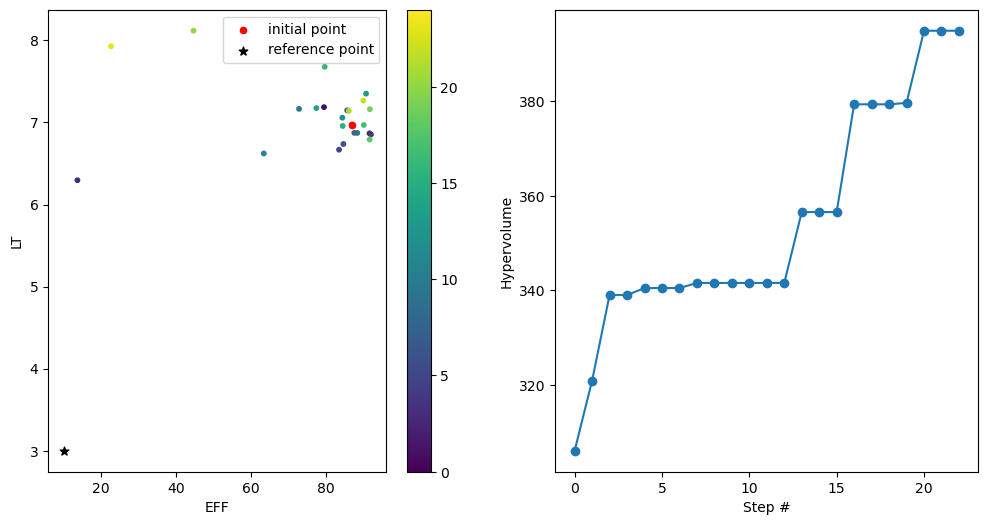

In [14]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

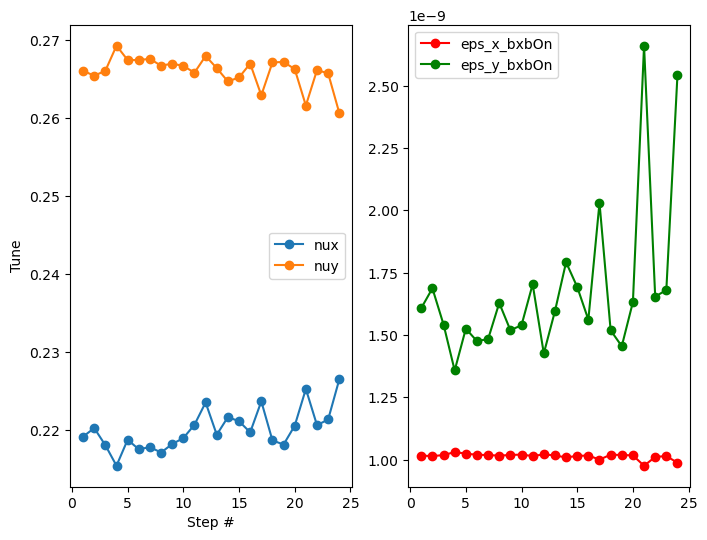

In [15]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [16]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')

In [20]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][20:26:21.119 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:26:21.121 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': 0.0, 'SL3': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][20:26:21.126 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 7.135584290000001, 'SL3': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.171021682, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.164180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + +0.000 -> +7.136
SL3    : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (8.964e-07, 1.144e-06)
Orbit correction converged


[INFO ][20:26:25.178 opt_funcs.  734] Lifetime measurement START
[INFO ][20:26:31.324 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.119 (raw tau [hr] = 7.475, epsy [pm] = 16.25) (took 6.1 [s])
Inj. Eff. = 69.55 (took 17.8 [s])
Eval. func. finished.


[DEBUG][20:26:49.111 evaluators  211] Result: output={'result': {'_nux': 0.21981675755732505, '_nuy': 0.2657149130617568, '_eps_x_bxbOn': 1.011848648370043e-09, '_eps_y_bxbOn': 1.6240101073097063e-11, '_eps_x_bxbOff': 1.0151827102010265e-09, '_eps_y_bxbOff': 1.624559785781227e-11, 'LT': 7.118625301089786, '_raw_LT': 7.475097030945426, 'EFF': 69.55206848972699}, 'exception': None, 'traceback': '', 'wall_time': 27.988034321926534, 'cpu_time': 12.680545530000018}
[DEBUG][20:26:49.113 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:26:49.147 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_01_51-aps_mobo-bcbd87b566-cb154515/dump_auto_00024.json] in [0.02987]s


In [18]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,True,0.219176,0.266020,1.016565e-09,1.607868e-11,1.016943e-09,1.608161e-11,6.973175,7.016592,87.040288
2,0.026425,0.002476,0.017052,-0.016516,0.028783,0.040351,0.024927,0.019665,-0.020352,0.001763,...,True,0.220275,0.265379,1.014695e-09,1.687160e-11,1.015535e-09,1.678506e-11,7.186479,7.423471,79.566187
3,-0.027684,-0.007395,-0.016005,0.009247,-0.032985,-0.031105,-0.029236,-0.015280,0.025141,-0.000580,...,True,0.218077,0.266020,1.018644e-09,1.542094e-11,1.018839e-09,1.536097e-11,6.867130,6.791881,91.721684
4,-0.124934,0.001317,-0.085158,0.097587,-0.128924,-0.216601,-0.110325,-0.106122,0.086697,-0.011610,...,True,0.215453,0.269224,1.030741e-09,1.357841e-11,1.029585e-09,1.343107e-11,6.296005,5.837793,13.710311
5,-0.032148,-0.050062,-0.002918,-0.043328,-0.052957,0.032617,-0.054870,0.024720,0.054875,0.010537,...,True,0.218779,0.267393,1.024499e-09,1.525312e-11,1.019300e-09,1.515801e-11,6.854727,6.764829,92.103952
6,-0.066582,-0.018184,-0.040154,-0.052590,-0.140480,0.036889,-0.095658,-0.020787,0.098863,-0.001526,...,True,0.217558,0.267393,1.019837e-09,1.475601e-11,1.019969e-09,1.459302e-11,6.667901,6.462595,83.579686
7,-0.050949,-0.042117,-0.039218,-0.000249,-0.039036,-0.077466,0.036377,-0.050823,-0.035405,-0.005423,...,True,0.217833,0.267546,1.018928e-09,1.483689e-11,1.020676e-09,1.470371e-11,6.737303,6.561370,84.737263
8,0.038686,-0.027285,0.043680,0.002462,-0.010763,-0.032244,-0.115344,0.034288,0.099599,0.006195,...,True,0.217141,0.266661,1.016300e-09,1.628373e-11,1.017481e-09,1.603214e-11,7.147511,7.276649,85.748986
9,-0.051933,-0.031199,-0.044252,-0.031898,-0.089715,0.039801,-0.039083,-0.002467,0.043064,0.009487,...,True,0.218230,0.266936,1.019196e-09,1.519295e-11,1.021885e-09,1.504487e-11,6.873110,6.782085,87.649336
10,-0.128569,-0.021404,0.027540,-0.006948,0.027253,-0.015058,-0.058299,0.041869,0.048979,0.003409,...,True,0.218993,0.266630,1.020547e-09,1.539198e-11,1.020496e-09,1.528297e-11,6.872451,6.843297,88.445408


In [19]:
opt.generator.model.state_dict()

OrderedDict([('models.0.likelihood.noise_covar.raw_noise',
              tensor([0.0404], dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.noise_prior.concentration',
              tensor(1.1000, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.noise_prior.rate',
              tensor(0.0500, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('models.0.mean_module.raw_constant',
              tensor(-1.6666, dtype=torch.float64)),
             ('models.0.covar_module.raw_outputscale',
              tensor(1.4248, dtype=torch.float64)),
             ('models.0.covar_module.base_kernel.raw_lengthscale',
              tensor([[-1.3493, -2.2664, -0.8923, -0.6254, -0.8371, -0.6012, -0.5138, -0.6824,
